# Evaluation of network performance

In [1]:
import os,sys
currentdir = os.getcwd()
parentdir = os.path.dirname(currentdir)
sys.path.insert(0,parentdir) 

In [2]:
from io_utils.data_handling import simple_np_ds

In [3]:
from utils.engine import Engine

Let's first create a configuration object -we'll use this to set up our training engine

In [4]:
class CONFIG:
    pass
config=CONFIG()
config.batch_size_test = 1024
config.batch_size_train = 128
config.batch_size_val = 2048
config.lr=0.0005
config.device = 'gpu'
config.gpu_list=[2,3]
config.num_workers_train=8
config.num_workers_val=8
config.num_workers_test=8
config.dump_path = '../model_state_dumps'


In [5]:
from models.resnet import resnet50
model_CNN=resnet50(num_input_channels=6,num_classes=2)

In [6]:
#dset=simple_np_ds('/fast_scratch/atlas_images/',val_split=0.1,test_split=0.1,transform=rotate_chan)
dset=simple_np_ds('/fast_scratch/atlas_images/',val_split=0.1,test_split=0.1)
dset.transform=dset.cle_scale

computed average cluster E: 28.26490592956543


In [7]:
engine=Engine(model_CNN,dset,config)

Requesting GPUs. GPU list : [2, 3]
Main GPU : cuda:2
Using DataParallel on these devices: ['cuda:2', 'cuda:3']
CUDA is available
Creating a directory for run dump: ../model_state_dumps/20191224_142255/


In [8]:
for name, param in model_CNN.named_parameters():
    print("name of a parameter: {}, type: {}, parameter requires a gradient?: {}".
          format(name, type(param),param.requires_grad))

name of a parameter: conv1.weight, type: <class 'torch.nn.parameter.Parameter'>, parameter requires a gradient?: True
name of a parameter: bn1.weight, type: <class 'torch.nn.parameter.Parameter'>, parameter requires a gradient?: True
name of a parameter: bn1.bias, type: <class 'torch.nn.parameter.Parameter'>, parameter requires a gradient?: True
name of a parameter: layer1.0.conv1.weight, type: <class 'torch.nn.parameter.Parameter'>, parameter requires a gradient?: True
name of a parameter: layer1.0.bn1.weight, type: <class 'torch.nn.parameter.Parameter'>, parameter requires a gradient?: True
name of a parameter: layer1.0.bn1.bias, type: <class 'torch.nn.parameter.Parameter'>, parameter requires a gradient?: True
name of a parameter: layer1.0.conv2.weight, type: <class 'torch.nn.parameter.Parameter'>, parameter requires a gradient?: True
name of a parameter: layer1.0.bn2.weight, type: <class 'torch.nn.parameter.Parameter'>, parameter requires a gradient?: True
name of a parameter: laye

In [9]:
loc="../model_state_dumps/20191223_095927/"
engine.restore_state(loc+"DataParallelBEST.pth")
engine.dirpath=loc

Restoring state from ../model_state_dumps/20191223_095927/DataParallelBEST.pth
Restoration complete.


In [10]:
%%time
engine.validate()

val_iterations : 0
val_iterations : 1
val_iterations : 2
val_iterations : 3
val_iterations : 4
val_iterations : 5
val_iterations : 6
val_iterations : 7
val_iterations : 8
val_iterations : 9
val_iterations : 10
val_iterations : 11
val_iterations : 12
val_iterations : 13
val_iterations : 14
val_iterations : 15
val_iterations : 16
val_iterations : 17
val_iterations : 18
val_iterations : 19
val_iterations : 20
val_iterations : 21
val_iterations : 22
val_iterations : 23
24

Total val loss :  4.675129935145378 
Total val acc :  22.21771043346774 
Avg val loss :  0.1947970806310574 
Avg val acc :  0.9257379347278225
CPU times: user 9.04 s, sys: 7.33 s, total: 16.4 s
Wall time: 28.6 s


In [12]:
import numpy as np
labels_val=np.load(engine.dirpath + "labels.npy")
predictions_val=np.load(engine.dirpath + "predictions.npy")
softmax_out_val=np.load(engine.dirpath + "softmax.npy")

In [13]:
import matplotlib.pyplot as plt
%matplotlib inline

In [14]:
def plot_resp(labels,softmax_out):
    fig1, ax1 = plt.subplots(figsize=(12,8),facecolor="w")
    ax1.tick_params(axis="both", labelsize=20)
    softmax_out_val_p0_Ppp=softmax_out_val[labels_val==0][:,1]
    softmax_out_val_pp_Ppp=softmax_out_val[labels_val==1][:,1]
    
    bins=np.linspace(0.0,1.0,51)
    values, bins, patches = ax1.hist(softmax_out_val_p0_Ppp, bins=bins, 
                                    label= r'$\pi^{\mathrm{0}}$', color='blue', density=True,
                                    alpha=0.3)
    
    values, bins, patches = ax1.hist(softmax_out_val_pp_Ppp, bins=bins, 
                                    label= r'$\pi^{\mathrm{+}}$', color='red', density=True,
                                    alpha=0.3)
    ax1.legend(prop={'size': 16})
    ax1.set_xlabel('$P(e)$',fontweight='bold',fontsize=24,color='black')
    
    
    plt.show()

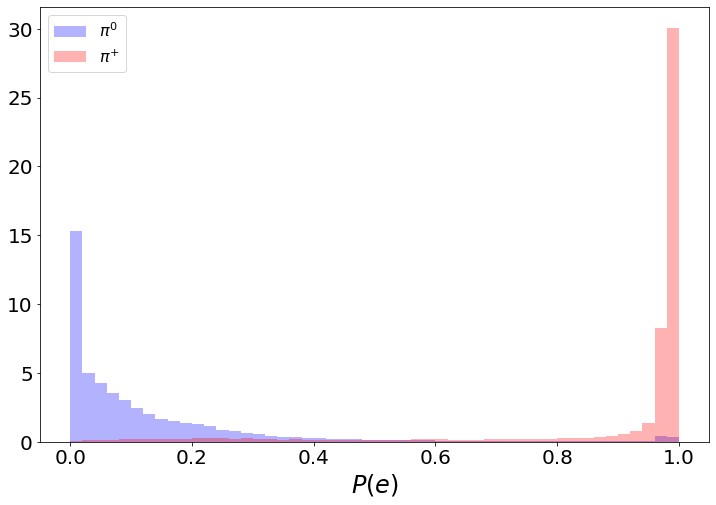

In [15]:
plot_resp(labels_val,softmax_out_val)

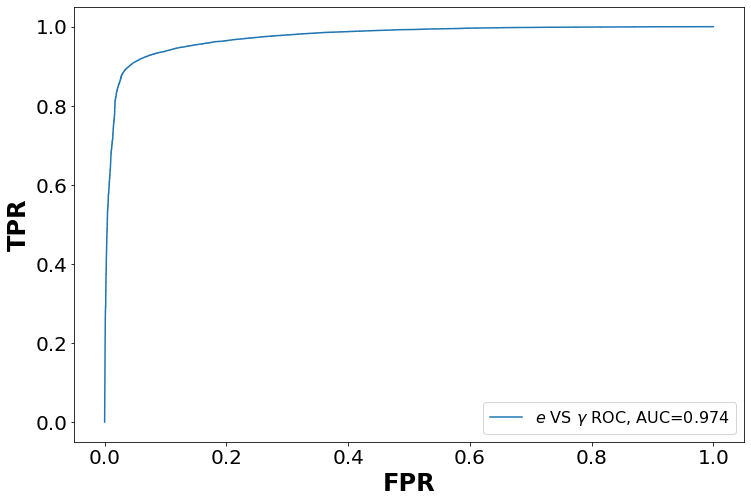

In [16]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
labels_val_e_gamma=labels_val[np.where( (labels_val==0) | (labels_val==1))]
softmax_out_val_e_gamma=softmax_out_val[np.where( (labels_val==0) | (labels_val==1))][:,1]
fpr,tpr,thr=roc_curve(labels_val_e_gamma,softmax_out_val_e_gamma)
roc_AUC=auc(fpr,tpr)
fig1, ax1 = plt.subplots(figsize=(12,8),facecolor="w")
ax1.tick_params(axis="both", labelsize=20)
ax1.plot(fpr,tpr,label=r'$e$ VS $\gamma$ ROC, AUC={:.3f}'.format(roc_AUC))
ax1.set_xlabel('FPR',fontweight='bold',fontsize=24,color='black')
ax1.set_ylabel('TPR',fontweight='bold',fontsize=24,color='black')
ax1.legend(loc="lower right",prop={'size': 16})